In [43]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import scipy.optimize as opt
import regularized_optimization as reg_opt
import Utilityfunctions as utils
import jax.numpy as jnp
import numpy as np
import jax as jax
import matplotlib.pyplot as plt
from jx import likelihood as lik
jax.config.update("jax_enable_x64", True)

ModuleNotFoundError: jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.

In [42]:
#mut_handle = "../data/paad/G12_PAADPANET_PM_z10_EventsAEP.csv"
#mut_handle = "../data/paad/G12_PAADPANET_PM_z10_Events_Mut50_Full.csv"
mut_handle = "../data/paad/G12_PAADPANET_PM_z10_Events_30and5_Full.csv"
annot_handle = "../data/paad/G12_PAADPANET_PM_z10_sampleSelection.csv"
#mut_handle = "../data/luad/G13_LUAD_PM_z1_Events_20and8_Full.csv"
#annot_handle = "../data/luad/G13_LUAD_PM_z1_sampleSelection_20and8.csv"
annot_data = pd.read_csv(annot_handle)
mut_data = pd.read_csv(mut_handle)
mut_data.rename(columns={"Unnamed: 0":"patientID"}, inplace = True)
dat = pd.merge(mut_data, annot_data.loc[:, ['patientID', 'metaStatus']], on=["patientID", "patientID"])

# Remove datapoints, that consist solely of NaNs
dat = dat.loc[dat.iloc[:,1:-3].isna().all(axis=1) == False, :]
dat = dat.loc[(dat.iloc[:,1:-3].sum(axis=1) > 0), :]
dat.columns

Index(['patientID', 'P.Mut.KRAS', 'M.Mut.KRAS', 'P.Mut.TP53', 'M.Mut.TP53',
       'P.gAEP033', 'M.gAEP033', 'P.chr18.del.single.1',
       'M.chr18.del.single.1', 'P.chrX.del.single.1', 'M.chrX.del.single.1',
       'P.Mut.SMAD4', 'M.Mut.SMAD4', 'P.chr20.amp.single.1',
       'M.chr20.amp.single.1', 'P.chr17.del.single.1', 'M.chr17.del.single.1',
       'P.Mut.CDKN2A', 'M.Mut.CDKN2A', 'P.Mut.ARID1A', 'M.Mut.ARID1A',
       'P.Mut.RNF43', 'M.Mut.RNF43', 'P.Mut.MEN1', 'M.Mut.MEN1',
       'P.Mut.TGFBR2', 'M.Mut.TGFBR2', 'P.Mut.KDM6A', 'M.Mut.KDM6A',
       'P.Mut.KMT2D', 'M.Mut.KMT2D', 'P.Mut.GNAS', 'M.Mut.GNAS', 'P.Mut.DAXX',
       'M.Mut.DAXX', 'P.Mut.KMT2C', 'M.Mut.KMT2C', 'P.Mut.ATM', 'M.Mut.ATM',
       'P.Mut.RBM10', 'M.Mut.RBM10', 'P.Mut.BRCA2', 'M.Mut.BRCA2',
       'P.Mut.SETD2', 'M.Mut.SETD2', 'P.Mut.ATRX', 'M.Mut.ATRX',
       'P.Mut.PIK3CA', 'M.Mut.PIK3CA', 'P.Mut.RB1', 'M.Mut.RB1',
       'P.Mut.TGFBR1', 'M.Mut.TGFBR1', 'P.Mut.SMARCA4', 'M.Mut.SMARCA4',
       'P.Mut.SMAD3

In [12]:
start = 'P.Mut.KRAS'
stop = 'M.Mut.PTPRT'
mult = dat.set_index(["paired", "metaStatus"])
cleaned = mult.loc[zip(*[[0,0,0,1],["present", "absent", "isMetastasis", "isPaired"]]), start:stop]
cleaned = cleaned.sort_index()
cleaned.loc[(0, ["present", "isMetastasis"]), "Seeding"] = 1
cleaned.loc[(0, "absent"), "Seeding"] = 0
cleaned.loc[(1, "isPaired"), "Seeding"] = 1
dat_prim_nomet, dat_met_only, dat_prim_met, dat_coupled = utils.split_data(cleaned)
print(dat_prim_nomet.shape[0], dat_prim_met.shape[0], dat_coupled.shape[0], dat_met_only.shape[0])

2023-05-11 16:30:17.080024: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


118 973 74 1022


In [13]:
events = []
for elem in cleaned.columns.to_list()[::2]:
    iwas = elem.split(".")
    if len(iwas) > 2:
        if iwas[1]  == 'Mut':
            events.append(iwas[2] + " (M)")
        else:
            events.append(iwas[1] + " (" + iwas[2] + ")")
    elif len(iwas) == 2:
        events.append(iwas[1])
    else:
        events.append("Seeding")

In [14]:
rai = cleaned.loc[(0, "absent"),:]
print(cleaned.loc[(0, "absent")].iloc[:,0:-1:2])
cleaned.loc[(0, "absent")].iloc[:,0:-1:2].sum(axis=0)/cleaned.loc[(0, "absent")].shape[0]

                   P.Mut.KRAS  P.Mut.TP53  P.gAEP033  P.chr18.del.single.1  \
paired metaStatus                                                            
0      absent               0           0          1                     1   
       absent               0           0          0                     0   
       absent               1           1          0                     0   
       absent               0           0          1                     0   
       absent               1           0          0                     0   
...                       ...         ...        ...                   ...   
       absent               1           1          0                     0   
       absent               1           1          0                     0   
       absent               1           0          0                     0   
       absent               1           0          0                     0   
       absent               1           0          0            

P.Mut.KRAS              0.813559
P.Mut.TP53              0.584746
P.gAEP033               0.305085
P.chr18.del.single.1    0.330508
P.chrX.del.single.1     0.177966
P.Mut.SMAD4             0.211864
P.chr20.amp.single.1    0.161017
P.chr17.del.single.1    0.161017
P.Mut.CDKN2A            0.152542
P.Mut.ARID1A            0.076271
P.Mut.RNF43             0.059322
P.Mut.MEN1              0.084746
P.Mut.TGFBR2            0.050847
P.Mut.KDM6A             0.025424
P.Mut.KMT2D             0.050847
P.Mut.GNAS              0.050847
P.Mut.DAXX              0.008475
P.Mut.KMT2C             0.025424
P.Mut.ATM               0.008475
P.Mut.RBM10             0.016949
P.Mut.BRCA2             0.000000
P.Mut.SETD2             0.033898
P.Mut.ATRX              0.033898
P.Mut.PIK3CA            0.025424
P.Mut.RB1               0.025424
P.Mut.TGFBR1            0.025424
P.Mut.SMARCA4           0.000000
P.Mut.SMAD3             0.008475
P.Mut.MAP2K4            0.016949
P.Mut.TSC2              0.008475
P.Mut.BCOR

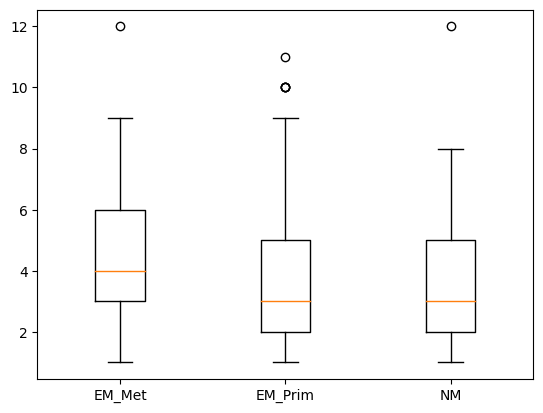

In [15]:
iwas = {"EM_Met":cleaned.loc[(0, "isMetastasis")].iloc[:, 1::2].sum(axis=1), 
        "EM_Prim":cleaned.loc[(0, "present")].iloc[:, 0:-1:2].sum(axis=1),
        "NM":cleaned.loc[(0, "absent")].iloc[:, 0:-1:2].sum(axis=1)}

fig, ax = plt.subplots()
ax.boxplot(iwas.values())
ax.set_xticklabels(iwas.keys())
plt.show()

In [16]:
n = (cleaned.shape[1]-1)//2
n += 1
lam1_start = np.log(30/162)
lam2_start = np.log(30/162) # observed mean time to second diagnosis is 87/162 days
indep = utils.indep(jnp.vstack((dat_met_only, dat_prim_met, dat_prim_nomet)), dat_coupled)
start_params = np.append(indep, [lam1_start, lam2_start])

In [17]:
utils.cross_val(cleaned, np.linspace(0.0001, 0.01, 5), 5, start_params, 0.8, n)

2023-05-30 18:55:29.386273: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 3m19.608777s

********************************
[Compiling module jit__g_coupled] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2023-05-30 19:29:13.573633: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 33m38.947327s

********************************
[Compiling module jit_gradient] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


split  0  fold:  0 res:  9.822244985335733
split  0  fold:  0 res:  9.855860997044472
--------------------------------------------------
split  1  fold:  0 res:  9.200991028817963
split  1  fold:  0 res:  9.13505536726847
--------------------------------------------------
split  2  fold:  0 res:  9.30742485616634
split  2  fold:  0 res:  9.138555922934911
--------------------------------------------------
split  3  fold:  0 res:  9.40293568532662
split  3  fold:  0 res:  9.233640943795809
--------------------------------------------------
split  4  fold:  0 res:  9.495192643295898
split  4  fold:  0 res:  9.297203055323038
--------------------------------------------------
split  0  fold:  1 res:  11.1021766009778
split  0  fold:  1 res:  11.113062774487481
--------------------------------------------------
split  1  fold:  1 res:  10.254770217225747
split  1  fold:  1 res:  10.104613604221878
--------------------------------------------------
split  2  fold:  1 res:  10.18446238457031

In [ ]:
n_mod = n-1
arr = dat_coupled * np.array([1,2]*n_mod+[1])
arr = arr @ (np.diag([1,0]*n_mod+[1]) + np.diag([1,0]*n_mod, -1))
counts = np.zeros((6, n))
for i in range(0,2*n,2):
    i_h = int(i/2)
    for j in range(1,4):
        counts[j-1, i_h] = np.count_nonzero(arr[:,i]==j)/dat_coupled.shape[0]
    counts[3, i_h] = np.sum(dat_prim_nomet[:, i], axis=0)/dat_prim_nomet.shape[0]
    counts[4, i_h] = (np.sum(dat_prim_met[:, i], axis=0))/dat_prim_met.shape[0]
    counts[5, i_h] = (np.sum(dat_met_only[:, i+1], axis=0))/dat_met_only.shape[0]

labels = [["Coupled ("+str(dat_coupled.shape[0])+")"]*3 +\
          ["NM ("+str(dat_prim_nomet.shape[0])+")"] +\
          ["EM-PT ("+str(dat_prim_met.shape[0])+")"] +\
          ["EM-MT ("+str(dat_met_only.shape[0])+")"],
          ["PT-Private", "MT-Private", "Shared"] + ["Present"]*3]
       
inds =  pd.MultiIndex.from_tuples(list(zip(*labels)))
iwas = pd.DataFrame(np.around(counts, 2), columns=events, index=inds).T
#iwas.to_latex("luad_samples.tex")
iwas

Coupled (74)                   NM (118) EM-PT (973) EM-MT (1022)
              PT-Private MT-Private Shared  Present     Present      Present
KRAS (M)            0.05       0.04   0.69     0.81        0.88         0.85
TP53 (M)            0.07       0.12   0.54     0.58        0.71         0.71
gAEP033             0.16       0.26   0.09     0.31        0.25         0.47
chr18 (del)         0.14       0.18   0.07     0.33        0.27         0.40
chrX (del)          0.11       0.12   0.05     0.18        0.15         0.28
SMAD4 (M)           0.04       0.04   0.19     0.21        0.20         0.19
chr20 (amp)         0.15       0.11   0.11     0.16        0.17         0.24
chr17 (del)         0.08       0.14   0.03     0.16        0.15         0.27
CDKN2A (M)          0.01       0.05   0.11     0.15        0.10         0.14
ARID1A (M)          0.01       0.04   0.07     0.08        0.08         0.09
RNF43 (M)           0.00       0.00   0.05     0.06        0.05         0.05
MEN1 (M)            0.00       0.00   0.09     0.08        0.04         0.04
TGFBR2 (M)          0.00       0.01   0.00     0.05        0.04         0.03
KDM6A (M)           0.00       0.00   0.00     0.03        0.04         0.04
KMT2D (M)           0.00       0.01   0.01     0.05        0.02         0.04
GNAS (M)            0.00       0.01   0.01     0.05        0.04         0.02
DAXX (M)            0.00       0.04   0.09     0.01        0.02         0.03
KMT2C (M)           0.00       0.01   0.04     0.03        0.03         0.02
ATM (M)             0.00       0.01   0.04     0.01        0.02         0.03
RBM10 (M)           0.00       0.00   0.00     0.02        0.03         0.02
BRCA2 (M)           0.00       0.03   0.03     0.00        0.02         0.03
SETD2 (M)           0.00       0.04   0.01     0.03        0.02         0.02
ATRX (M)            0.01       0.01   0.03     0.03        0.02         0.02
PIK3CA (M)          0.00       0.00   0.00     0.03        0.02         0.03
RB1 (M)             0.00       0.00   0.01     0.03        0.02         0.02
TGFBR1 (M)          0.01       0.00   0.00     0.03        0.02         0.02
SMARCA4 (M)         0.04       0.01   0.00     0.00        0.01         0.02
SMAD3 (M)           0.00       0.03   0.00     0.01        0.02         0.01
MAP2K4 (M)          0.00       0.00   0.01     0.02        0.01         0.02
TSC2 (M)            0.00       0.05   0.01     0.01        0.01         0.02
BCOR (M)            0.00       0.00   0.00     0.02        0.01         0.01
U2AF1 (M)           0.01       0.01   0.00     0.01        0.01         0.02
SF3B1 (M)           0.00       0.00   0.01     0.01        0.01         0.01
STK11 (M)           0.00       0.00   0.00     0.01        0.01         0.01
PTPRT (M)           0.00       0.01   0.00     0.03        0.01         0.01
Seeding             1.00       0.00   0.00     0.00        1.00         1.00

In [ ]:
penal1 = 0.005 # L1 penalty on off-diagonals
penal2 = 0.005 # L2 penalty on diagonals
m_p_corr = 0.8
x = opt.minimize(reg_opt.value_grad, x0 = start_params, args = (dat_prim_nomet, dat_coupled, dat_prim_met, dat_met_only, n-1, penal1, penal2,  m_p_corr), 
                method = "L-BFGS-B", jac = True, options={"maxiter":10000, "disp":True, "ftol":1e-04})

In [ ]:
print(1/jnp.exp(x.x[-2]))
df2 = pd.DataFrame(x.x[:-2].reshape((n, n)), columns=events, index=events)
theta = df2.copy()
df2["Sampling"] = np.append(np.array(x.x[-2:]), np.zeros(n-2))
df2.to_csv("../results/test.csv")
df2.round(3)

In [ ]:
utils.plot_theta(theta, 0.5)